# 🧠 OASIS – Preprocesamiento y Feature Engineering (Cortes Coronales)

Este notebook implementa el pipeline de extracción de características para detectar
Alzheimer en etapas tempranas a partir de cortes coronales del dataset OASIS.

- Normalización z-score sobre voxeles no cero
- Recorte a brain bounding box
- Redimensionamiento a 224×224

## Contenido
- Construcción de 3 canales: **original normalizada**, **Sobel (bordes)** y **diff vs plantilla CN**.
- Feature engineering de imágenes:
  - Grilla 16×16: mean y std por celda + selección de TOP-20 celdas más discriminativas.
  - Proxies anatómicos: `brain_fraction`, `central_peripheral_ratio`, `average_width`.
  - Edge features: `edge_energy` global + `edge_central` (ROI central).
  - Distancia a plantilla CN (L2 global y por ROI central).
  - Texturas (GLCM + LBP) en ROI temporal / medial aproximada.
- Exportación de un dataset tabular (`features_oasis_coronal.csv`) listo para modelos de ML.


## 0. Imports y configuración de rutas

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from scipy import ndimage
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pandas as pd
import seaborn as sns

BASE_DIR = r"C:\\Users\\mmera\\OneDrive\\Escritorio\\ProyectoMineria\\proyectoMineria"
IMG_DIR = os.path.join(BASE_DIR, 'data', 'processed', 'OASIS_2D')  # CN / MCI / AD

classes = ['CN', 'MCI', 'AD']
# Buscar imágenes estandarizadas (_std.png, ya procesadas por notebook 2_IMAGE_NORMALIZATION.ipynb)
paths = {}
for c in classes:
    # Buscar solo imágenes con sufijo _std.png (imágenes normalizadas)
    all_images = glob(os.path.join(IMG_DIR, c, '*_std.png'))
    paths[c] = sorted(all_images)

for c in classes:
    print(f"{c}: {len(paths[c])} imágenes estandarizadas encontradas")


CN: 10626 imágenes estandarizadas encontradas
MCI: 18118 imágenes estandarizadas encontradas
AD: 6512 imágenes estandarizadas encontradas


## 1. Plantilla promedio CN
Calculamos una imagen plantilla promedio para la clase CN usando imágenes **ya estandarizadas** (224×224, normalizadas).
Esta plantilla se usará para construir el canal `diff_vs_mean_CN` y para las distancias L2.

Shape CN estandarizadas: (10626, 224, 224)


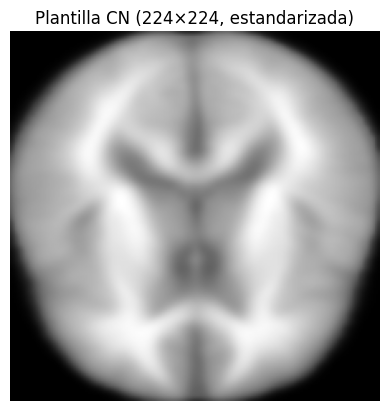

In [3]:
def load_standardized(path):
    """Carga una imagen ya estandarizada (224×224, normalizada z-score)."""
    img = np.array(Image.open(path).convert('L'), dtype=np.float32)
    # Las imágenes estandarizadas están en rango 0-255, pero representan valores normalizados
    # Convertimos de vuelta a valores normalizados aproximados
    # (Nota: esto es una aproximación, pero suficiente para el feature engineering)
    img = (img.astype(np.float32) - img.mean()) / (img.std() + 1e-6)
    return img

cn_imgs = [load_standardized(p) for p in paths['CN']]
cn_imgs = np.stack(cn_imgs, axis=0) if len(cn_imgs) > 0 else None
print('Shape CN estandarizadas:', None if cn_imgs is None else cn_imgs.shape)

mean_CN_224 = cn_imgs.mean(axis=0) if cn_imgs is not None else None
if mean_CN_224 is not None:
    plt.imshow(mean_CN_224, cmap='gray'); plt.title('Plantilla CN (224×224, estandarizada)'); plt.axis('off'); plt.show()


## 2. Funciones de procesamiento
**Nota:** Las funciones de estandarización (`zscore_nonzero`, `crop_brain`, `resize224`) ya no son necesarias aquí,
ya que las imágenes vienen estandarizadas del notebook 3.

Implementamos:
- `sobel_edges`: mapa de bordes.
- `prepare_three_channels`: construye los 3 canales propuestos a partir de imágenes ya estandarizadas.

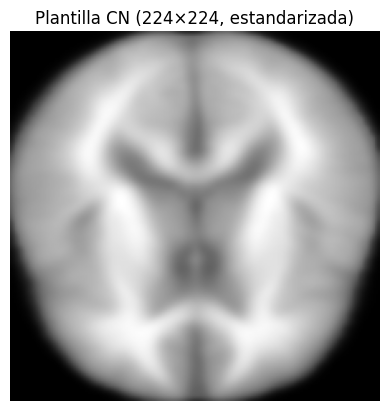

In [4]:
def sobel_edges(img: np.ndarray) -> np.ndarray:
    """Calcula el mapa de bordes usando filtro Sobel."""
    sx = ndimage.sobel(img, axis=0, mode='reflect')
    sy = ndimage.sobel(img, axis=1, mode='reflect')
    edges = np.hypot(sx, sy)
    return edges.astype(np.float32)

# La plantilla CN ya está calculada en la celda anterior (mean_CN_224)
if mean_CN_224 is not None:
    plt.imshow(mean_CN_224, cmap='gray'); plt.title('Plantilla CN (224×224, estandarizada)'); plt.axis('off'); plt.show()

def prepare_three_channels(img_standardized: np.ndarray) -> np.ndarray:
    """
    Construye 3 canales a partir de una imagen ya estandarizada (224×224, normalizada):
    1. Canal original (ya estandarizado)
    2. Sobel (bordes)
    3. Diff vs plantilla CN (normalizado)
    
    Args:
        img_standardized: Imagen ya estandarizada (224×224, normalizada z-score)
    
    Returns:
        Imagen de 3 canales (224, 224, 3)
    """
    # La imagen ya viene estandarizada (224×224, normalizada)
    img_224 = img_standardized
    
    # Canal 2: Sobel (bordes)
    edges = sobel_edges(img_224)
    
    # Canal 3: Diff vs plantilla CN
    if mean_CN_224 is not None:
        diff_cn = img_224 - mean_CN_224
    else:
        diff_cn = np.zeros_like(img_224)
    
    # Normalizamos Sobel y diff_cn a rangos comparables
    def norm_channel(ch):
        ch = ch - ch.mean()
        ch_std = ch.std() + 1e-6
        return ch / ch_std
    
    edges_n = norm_channel(edges)
    diff_n = norm_channel(diff_cn)
    
    # Apilar los 3 canales
    stacked = np.stack([img_224, edges_n, diff_n], axis=-1)  # (224, 224, 3)
    return stacked


### 2.1. Ejemplo visual de los 3 canales

Ejemplo: C:\\Users\\mmera\\OneDrive\\Escritorio\\ProyectoMineria\\proyectoMineria\data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-1.nifti_coronal_std.png


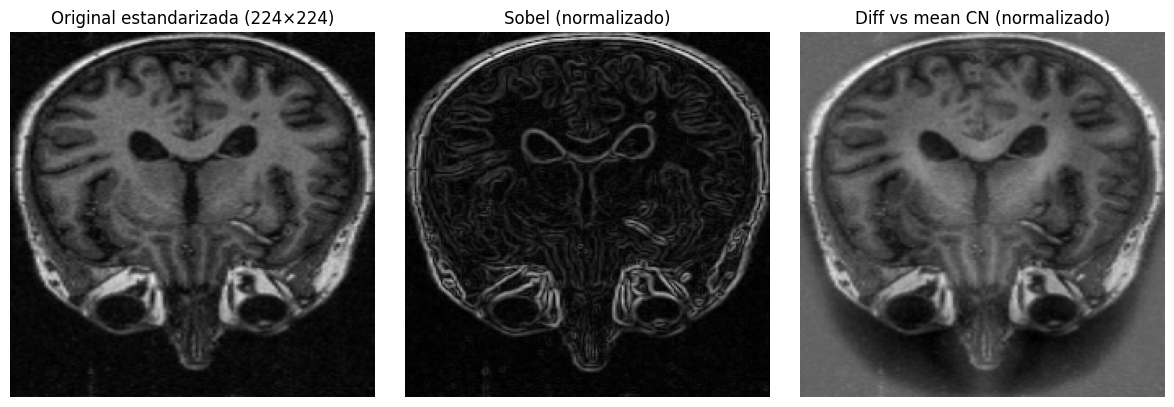

In [5]:
sample_path = paths['CN'][0] if len(paths['CN'])>0 else None
print('Ejemplo:', sample_path)
sample_std = load_standardized(sample_path)
sample_3ch = prepare_three_channels(sample_std)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
titles = ['Original estandarizada (224×224)', 'Sobel (normalizado)', 'Diff vs mean CN (normalizado)']
for i in range(3):
    axes[i].imshow(sample_3ch[:,:,i], cmap='gray')
    axes[i].set_title(titles[i])
    axes[i].axis('off')
plt.tight_layout(); plt.show()


## 3. Feature Engineering sobre imágenes
Definimos funciones para extraer características numéricas a partir de la imagen preprocesada (canal original 224×224).

In [6]:
GRID_SIZE = 16

def grid_features(img: np.ndarray, G: int = GRID_SIZE) -> np.ndarray:
    """Imagen (H,W) → concatena mean y std por celda de una grilla G×G."""
    H, W = img.shape
    h, w = H // G, W // G
    feats = []
    for i in range(G):
        for j in range(G):
            patch = img[i*h:(i+1)*h, j*w:(j+1)*w]
            if patch.size == 0:
                m = 0.0; s = 0.0
            else:
                m = patch.mean(); s = patch.std()
            feats.extend([m, s])
    return np.array(feats, dtype=np.float32)

def brain_fraction(img: np.ndarray) -> float:
    return float(np.mean(img > 0))

def central_peripheral_ratio(img: np.ndarray) -> float:
    H, W = img.shape
    cy1, cy2 = H//4, 3*H//4
    cx1, cx2 = W//4, 3*W//4
    central = img[cy1:cy2, cx1:cx2]
    peripheral = img.copy()
    peripheral[cy1:cy2, cx1:cx2] = 0
    cen_mean = central[central>0].mean() if np.any(central>0) else 0.0
    per_mask = peripheral > 0
    per_mean = peripheral[per_mask].mean() if np.any(per_mask) else 1e-6
    return float(cen_mean / (per_mean + 1e-6))

def average_width(img: np.ndarray) -> float:
    widths = []
    for row in img:
        xs = np.where(row > 0)[0]
        if len(xs) > 0:
            widths.append(xs.max() - xs.min())
    return float(np.mean(widths)) if len(widths) > 0 else 0.0

def edge_energy(edge_img: np.ndarray) -> float:
    return float(np.mean(edge_img**2))

def edge_central(edge_img: np.ndarray) -> float:
    H, W = edge_img.shape
    cy1, cy2 = H//4, 3*H//4
    cx1, cx2 = W//4, 3*W//4
    central = edge_img[cy1:cy2, cx1:cx2]
    return float(central.mean())

def distance_cn(img: np.ndarray, mean_cn: np.ndarray) -> float:
    diff = img - mean_cn
    return float(np.linalg.norm(diff.ravel(), ord=2))

def distance_cn_central(img: np.ndarray, mean_cn: np.ndarray) -> float:
    H, W = img.shape
    cy1, cy2 = H//4, 3*H//4
    cx1, cx2 = W//4, 3*W//4
    cen1 = img[cy1:cy2, cx1:cx2]
    cen2 = mean_cn[cy1:cy2, cx1:cx2]
    diff = cen1 - cen2
    return float(np.linalg.norm(diff.ravel(), ord=2))

def texture_features(img: np.ndarray) -> np.ndarray:
    """Texturas GLCM + LBP en una ROI central aproximada."""
    H, W = img.shape
    cy1, cy2 = H//4, 3*H//4
    cx1, cx2 = W//4, 3*W//4
    roi = img[cy1:cy2, cx1:cx2]
    # Normalizar a 0-255
    if roi.max() > roi.min():
        roi_norm = (roi - roi.min()) / (roi.max() - roi.min())
    else:
        roi_norm = roi - roi.min()
    roi_u8 = (roi_norm * 255).astype(np.uint8)

    glcm = graycomatrix(roi_u8, [1], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    correlation = graycoprops(glcm, 'correlation')[0,0]

    lbp = local_binary_pattern(roi_u8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 10), density=True)

    feats = np.concatenate([[contrast, homogeneity, correlation], lbp_hist])
    return feats.astype(np.float32)


### 3.1. Función maestra de extracción de features por imagen

In [7]:
def extract_features_for_image(img_standardized: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Recibe una imagen ya estandarizada (224×224, normalizada) y regresa:
    - img_224 (canal original estandarizado, 224×224)
    - feature vector 1D
    
    Args:
        img_standardized: Imagen ya estandarizada (224×224, normalizada z-score)
    
    Returns:
        Tupla (imagen base, vector de features)
    """
    # La imagen ya viene estandarizada (224×224, normalizada)
    img_224 = img_standardized
    # Canal original
    base = img_224
    # Features de grilla
    grid_feats = grid_features(base)
    # Proxies anatómicos
    bf = brain_fraction(base)
    cpr = central_peripheral_ratio(base)
    aw = average_width(base)
    # Edge features
    edges = sobel_edges(base)
    ee = edge_energy(edges)
    ec = edge_central(edges)
    # Distancias a CN
    dcn = distance_cn(base, mean_CN_224)
    dcn_c = distance_cn_central(base, mean_CN_224)
    # Texturas
    tex = texture_features(base)
    # Concatenar todo
    feats = np.concatenate([
        grid_feats,
        np.array([bf, cpr, aw, ee, ec, dcn, dcn_c], dtype=np.float32),
        tex
    ])
    return base, feats

# Prueba rápida
base_example, feats_example = extract_features_for_image(sample_std)
print('Imagen base shape:', base_example.shape)
print('Vector de features shape:', feats_example.shape)


Imagen base shape: (224, 224)
Vector de features shape: (532,)


## 4. Extracción de features para todo el dataset
Vamos a recorrer todas las imágenes de CN, MCI y AD, aplicar el preprocesamiento y extraer
las características numéricas en un `DataFrame`.

In [9]:
records = []

for label in classes:
    for p in paths[label]:
        img_standardized = load_standardized(p)
        base_img, feats = extract_features_for_image(img_standardized)
        rec = {
            'filepath': os.path.relpath(p, BASE_DIR),
            'label': label
        }
        # Expand features into columns f_0, f_1, ...
        for i, val in enumerate(feats):
            rec[f'f_{i}'] = float(val)
        records.append(rec)

df_feats = pd.DataFrame.from_records(records)
print(df_feats.shape)
df_feats.head()


(35256, 534)


,filepath,label,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_522,f_523,f_524,f_525,f_526,f_527,f_528,f_529,f_530,f_531
0,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-1...,CN,-1.013416,0.081918,-1.009376,0.091144,-1.016879,0.087303,-0.663185,0.733431,...,0.036432,0.072305,0.069356,0.142219,0.243064,0.150749,0.076371,0.064573,0.053811,0.091119
1,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-2...,CN,-0.969129,0.077671,-0.972200,0.080683,-0.980976,0.086060,-0.850111,0.294578,...,0.038106,0.071030,0.068320,0.141024,0.242746,0.156330,0.078922,0.064892,0.050861,0.087771
2,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-3...,CN,-0.997219,0.071088,-1.005668,0.068805,-0.981637,0.077681,-0.871683,0.279417,...,0.036511,0.065689,0.065928,0.141980,0.258849,0.159279,0.076371,0.062341,0.047752,0.085300
3,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-4...,CN,-0.984324,0.076768,-1.005364,0.070510,-1.005258,0.065332,-0.911426,0.255307,...,0.039302,0.067682,0.066566,0.139748,0.248724,0.159279,0.077328,0.061464,0.051419,0.088489
4,data\processed\OASIS_2D\CN\OAS2_0100_MR2_mpr-1...,CN,-1.252432,0.074646,-1.239501,0.073989,-1.228084,0.096503,-1.114849,0.205981,...,0.034120,0.063138,0.064254,0.145169,0.261240,0.171556,0.078683,0.054767,0.046317,0.080756


## 5. Selección de TOP-20 celdas de grilla más discriminativas
Usamos las features de grilla (mean y std por celda) para identificar qué regiones cambian más
entre CN y AD. Nos quedamos con las 20 celdas con mayor diferencia absoluta en la media.

🧠 Por qué las features de la grilla (mean/std por celda) son las más discriminativas

## 1️⃣ ¿Qué representan estas features?

Cada **celda de la grilla 16×16** representa una **región espacial fija** del corte coronal (por ejemplo, una ventana 14×14 px dentro de la imagen reescalada a 224×224).

Para cada celda calculamos:

* **mean** → cuánta “intensidad promedio” hay en esa parte del cerebro
* **std** → cuánta variabilidad local tiene la estructura (cortes, bordes, textura)

En total:

* 16×16 = 256 celdas
* Cada celda aporta mean + std → 512 features (f_0…f_511)

Estas features capturan **información anatómica localizada**.

---

## 2️⃣ ¿Por qué se comparan CN vs AD?

```python
cn_grid = df_feats[df_feats['label']=='CN'][grid_cols].mean(axis=0)
ad_grid = df_feats[df_feats['label']=='AD'][grid_cols].mean(axis=0)
diff = (ad_grid - cn_grid).abs()
```

Esto calcula:

* **Promedio de cada celda para todos los sujetos normales (CN)**
* **Promedio de la misma celda en sujetos con Alzheimer (AD)**
* **Diferencia absoluta entre ambas**

Luego seleccionamos las 20 celdas donde esa diferencia es mayor:

```python
top20_idx = diff.sort_values(ascending=False).index[:20]
```

Estas son las regiones que **más cambian entre CN y AD**.

---

## 3️⃣ ¿Por qué esas celdas son las más discriminativas?

✔ Razón 1: El Alzheimer produce atrofia **regional**, no global

Tu EDA previa ya lo mostraba (coronal plots y mapas por secciones):
Las mayores diferencias entre CN y AD aparecen en:

* **Lóbulos temporales mediales**
* **Hipocampo**
* **Región parahipocampal**
* **Alrededor de los ventrículos laterales**

Estas áreas se encuentran en **partes muy específicas del corte coronal**.

Es decir:
✔ no cambia toda la imagen por igual,
✘ no cambia la media global,
✔ cambian regiones anatómicas concretas.

Por eso, los valores **mean** de esas celdas bajan en AD (menos masa, más LCR → menor intensidad).

---

✔ Razón 2: Los ventrículos se expanden en AD → aumentan intensidades bajas

En tus imágenes:

* CN → ventrículos normales
* AD → ventrículos más grandes (más negro / intensidades bajas en MRI T1)

Esto causa:

* **celda(s) cerca del centro → mean más bajo en AD**
* **std más alto** (mezcla de tejido y LCR)

La diferencia CN–AD en esas celdas es muy marcada → alta discriminación.

---

✔ Razón 3: El hipocampo se reduce → bordes menos definidos

En las regiones cerca del hipocampo:

* La intensidad media baja.
* La desviación estándar puede aumentar (más variabilidad por atrofia).

El grid captura exactamente esas regiones porque mantiene la estructura espacial.

---

✔ Razón 4: Mean/Std son estadísticas muy sensibles a atrofias regionales

La atrofia altera:

* tamaño,
* textura,
* presencia de LCR,
* densidad de sustancia gris/ blanca.

Cada una de estas cosas afecta directamente:

* mean → baja intensidad
* std → diferencias de contorno o mezcla de tejidos

y las celdas de la grilla lo capturan con precisión milimétrica.

---

## 4️⃣ ¿Por qué no fueron más discriminativas las features globales?

Tus EDA mostraron:

* mean global similar entre CN, MCI, AD
* std global muy similar
* histograma global muy solapado

¿Por qué?

Porque **el cerebro completo sigue ocupando la mayor parte del corte**, incluso con atrofia.
La expansión de ventrículos y la pérdida de hipocampo afectan pequeñas zonas, que se pierden al promediar toda la imagen.

La grilla (especialmente 16×16) **preserva la señal regional** → lo que realmente distingue AD temprano.

---

## 5️⃣ Conclusión

Las features de la grilla son las más discriminativas porque:

🧩 1. Capturan **información espacial localizada**, crítica para Alzheimer.

🧠 2. Detectan atrofia en regiones anatómicas clave (hipocampo, temporal medial, ventrículos).

📉 3. Mean/Std cambian de forma significativa en esas regiones.

🎯 4. La atrofia no es global → los features globales pierden información.

🚀 5. La grilla funciona como un “atlas aproximado” sin segmentación.

En otras palabras:

**El Alzheimer deja patrones espaciales, no globales.
La grilla detecta esos patrones.**


In [10]:
# Localizamos cuáles columnas del DataFrame corresponden a la grilla.
# Por construcción, grid_features va primero, así que f_0 .. f_{2*G^2-1} son mean/std por celda.
G = GRID_SIZE
num_grid_feats = 2 * G * G
grid_cols = [f'f_{i}' for i in range(num_grid_feats)]

cn_grid = df_feats[df_feats['label']=='CN'][grid_cols].mean(axis=0)
ad_grid = df_feats[df_feats['label']=='AD'][grid_cols].mean(axis=0)
diff = (ad_grid - cn_grid).abs()

top20_idx = diff.sort_values(ascending=False).index[:20]
print('TOP-20 columnas más discriminativas (grilla):')
print(top20_idx.tolist())


TOP-20 columnas más discriminativas (grilla):
['f_168', 'f_170', 'f_136', 'f_204', 'f_202', 'f_270', 'f_182', 'f_300', 'f_332', 'f_164', 'f_364', 'f_166', 'f_200', 'f_302', 'f_102', 'f_212', 'f_172', 'f_167', 'f_210', 'f_372']


### 5.1. Sub-DataFrame sólo con TOP-20 features de grilla
Podemos crear una versión reducida del dataset que use únicamente estas features de grilla +
las demás features globales/proxies/texturas.

In [11]:
other_cols = [c for c in df_feats.columns if c.startswith('f_') and c not in top20_idx]
# Si quisiéramos un dataset sólo con top20 de grilla + resto, podemos reordenar
ordered_cols = ['filepath', 'label'] + list(top20_idx) + other_cols
df_feats_reordered = df_feats[ordered_cols]
df_feats_reordered.head()


,filepath,label,f_168,f_170,f_136,f_204,f_202,f_270,f_182,f_300,...,f_522,f_523,f_524,f_525,f_526,f_527,f_528,f_529,f_530,f_531
0,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-1...,CN,1.066037,0.372963,1.230763,0.754592,1.035331,0.164371,1.063728,0.452959,...,0.036432,0.072305,0.069356,0.142219,0.243064,0.150749,0.076371,0.064573,0.053811,0.091119
1,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-2...,CN,0.874278,0.947334,1.175826,0.916071,0.996148,0.419048,1.153449,0.622530,...,0.038106,0.071030,0.068320,0.141024,0.242746,0.156330,0.078922,0.064892,0.050861,0.087771
2,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-3...,CN,0.883734,0.782559,1.133928,0.837536,1.015525,0.417803,1.204377,0.581087,...,0.036511,0.065689,0.065928,0.141980,0.258849,0.159279,0.076371,0.062341,0.047752,0.085300
3,data\processed\OASIS_2D\CN\OAS2_0100_MR1_mpr-4...,CN,0.905050,0.801974,1.159871,0.812706,0.958394,0.386482,1.221185,0.547047,...,0.039302,0.067682,0.066566,0.139748,0.248724,0.159279,0.077328,0.061464,0.051419,0.088489
4,data\processed\OASIS_2D\CN\OAS2_0100_MR2_mpr-1...,CN,0.050942,-0.041673,1.070645,0.367000,-0.479005,0.134704,1.112468,0.982224,...,0.034120,0.063138,0.064254,0.145169,0.261240,0.171556,0.078683,0.054767,0.046317,0.080756


## 6. Exportar features a CSV
Guardamos el dataset de características para su uso posterior en modelos de clasificación.

In [12]:
OUTPUT_DIR = os.path.join(BASE_DIR, 'data', 'processed')
os.makedirs(OUTPUT_DIR, exist_ok=True)
csv_path = os.path.join(OUTPUT_DIR, 'features_oasis_coronal.csv')
df_feats_reordered.to_csv(csv_path, index=False)
print('CSV guardado en:', csv_path)


CSV guardado en: C:\\Users\\mmera\\OneDrive\\Escritorio\\ProyectoMineria\\proyectoMineria\data\processed\features_oasis_coronal.csv


# 🔥 HEATMAP DE DIFERENCIAS CN–AD EN LA GRILLA 16×16

TOP-20 features más discriminativas:
['f_168', 'f_170', 'f_136', 'f_204', 'f_202', 'f_270', 'f_182', 'f_300', 'f_332', 'f_164', 'f_364', 'f_166', 'f_200', 'f_302', 'f_102', 'f_212', 'f_172', 'f_167', 'f_210', 'f_372']


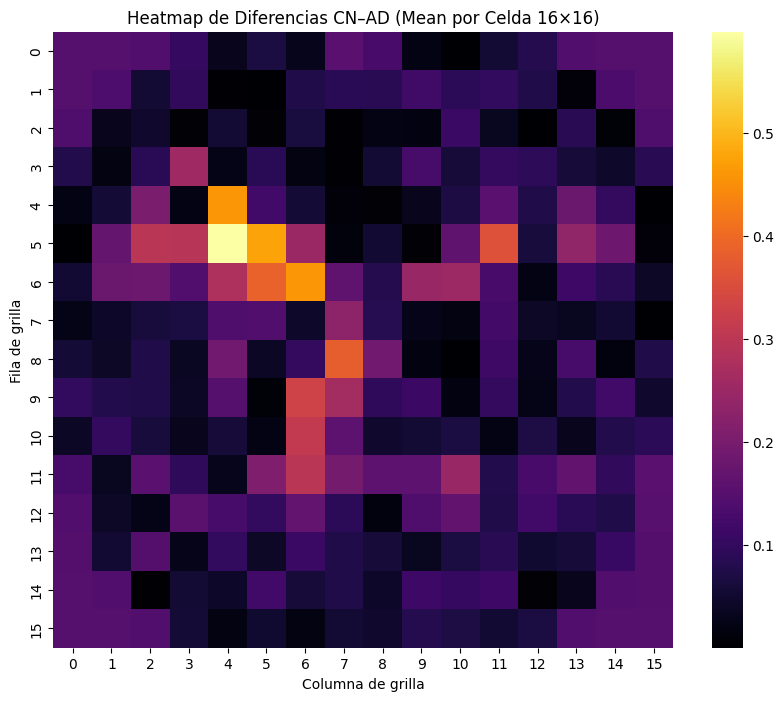

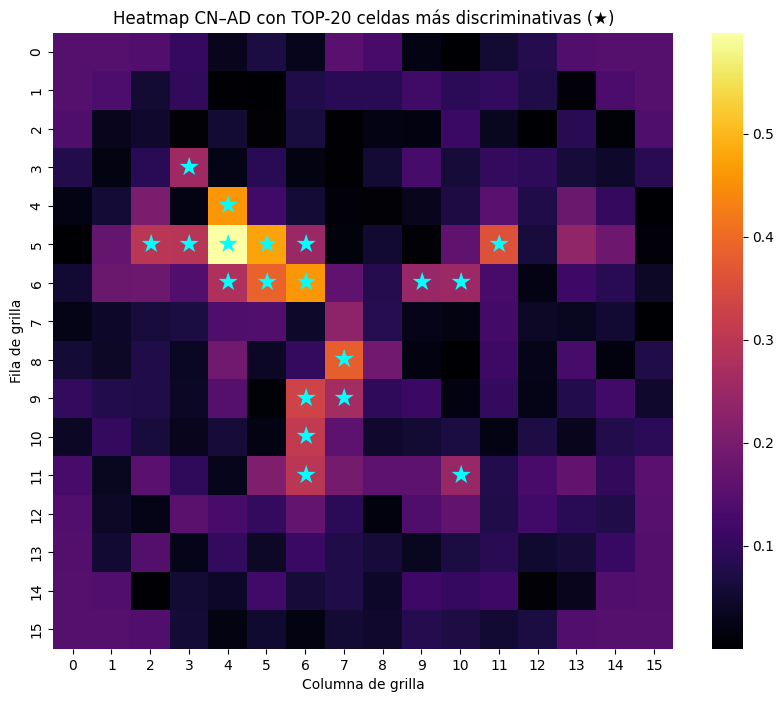

In [13]:
import seaborn as sns

CSV_PATH = r"C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria\data\processed\features_oasis_coronal.csv"
df = pd.read_csv(CSV_PATH)

# -----------------------------
# Seleccionar únicamente columnas de grilla
# grid_features produce 2*(G*G) columnas
# → mean y std por celda
# Aquí G = 16 → 512 columnas
# -----------------------------
G = 16
num_grid_feats = 2 * G * G
grid_cols = [f"f_{i}" for i in range(num_grid_feats)]

# Agrupar por clase
cn_mean = df[df["label"] == "CN"][grid_cols].mean(axis=0)
ad_mean = df[df["label"] == "AD"][grid_cols].mean(axis=0)

# Diferencias absolutas CN–AD
diff = (ad_mean - cn_mean).abs()

top20 = diff.sort_values(ascending=False).index[:20]
print("TOP-20 features más discriminativas:")
print(top20.tolist())

mean_indices = [i for i in range(num_grid_feats) if i % 2 == 0]
diff_mean = diff[[f"f_{i}" for i in mean_indices]]

# Crear matriz 16×16
heatmap_matrix = diff_mean.values.reshape(G, G)

# -----------------------------
# Plot del heatmap
# -----------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_matrix, cmap="inferno", annot=False, cbar=True)
plt.title("Heatmap de Diferencias CN–AD (Mean por Celda 16×16)")
plt.xlabel("Columna de grilla")
plt.ylabel("Fila de grilla")
plt.show()

# Heatmap con TOP-20 celdas marcadas
# Crear una matriz booleana para marcar top-20
mask_top20 = np.zeros((G, G))

# Convertir top20 a índices (mean only)
top20_mean_indices = [int(idx.replace("f_", "")) for idx in top20 if int(idx.replace("f_","")) % 2 == 0]

for idx in top20_mean_indices:
    cell = idx // 2  # dividir entre 2 porque mean ocupa índices pares
    r = cell // G
    c = cell % G
    mask_top20[r, c] = 1

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_matrix, cmap="inferno", cbar=True)

# Overlay de las celdas top-20
for r in range(G):
    for c in range(G):
        if mask_top20[r, c] == 1:
            plt.text(c + 0.5, r + 0.5, "★",
                     ha="center", va="center", color="cyan", fontsize=18)

plt.title("Heatmap CN–AD con TOP-20 celdas más discriminativas (★)")
plt.xlabel("Columna de grilla")
plt.ylabel("Fila de grilla")
plt.show()
